# 고객을 세그먼테이션하자! 

요약: SQL을 사용하여 RFM 분석을 더 큰 데이터셋에 적용해보는 프로젝트  
목표: 데이터에 근거하여 고객들을 분류하고 이를 시각화해서 각 타겟별 타겟팅 전략을 세울 수 있게 된다.  
시기: 2024년 1월 15일 10:00 ~ 18:00

## Recency, Frequency, Monetary에 기반한 고객 분류

RFM 분석: 구매 최신성(Recency), 구매 빈도(Frequency), 구매 가치(Monetary)에 따라 고객들을 여러 그룹으로 나누는 세그멘테이션(segmentation) 방법

- Recency: 고객이 마지막으로 구매한 시점
    - 최근에 구매한 고객들은 더 자주 구매할 가능성이 높기 때문에, 최신성 점수가 높은지 고려한다.
- Frequency: 특정 기간 동안 고객이 얼마나 자주 우리 제품이나 서비스를 구매하는가
    - 빈번하게 구매를 하는 고객은 더 충성도가 높은 고객일 확률이 높기 때문에, 빈도수 점수가 높은지 고려한다.
- Monetary: 고객이 지출한 총 금액
    - 높은 금액을 지분한 고객일 수록 더 가치가 높은 충성 고객일 수 있다.
    - 앞으로도 우리 제품과 사이트에 많은 돈을 지불할 수 있는 고객이므로, 가치 점수가 높은지를 함께 고려한다.

## 분석 프로세스

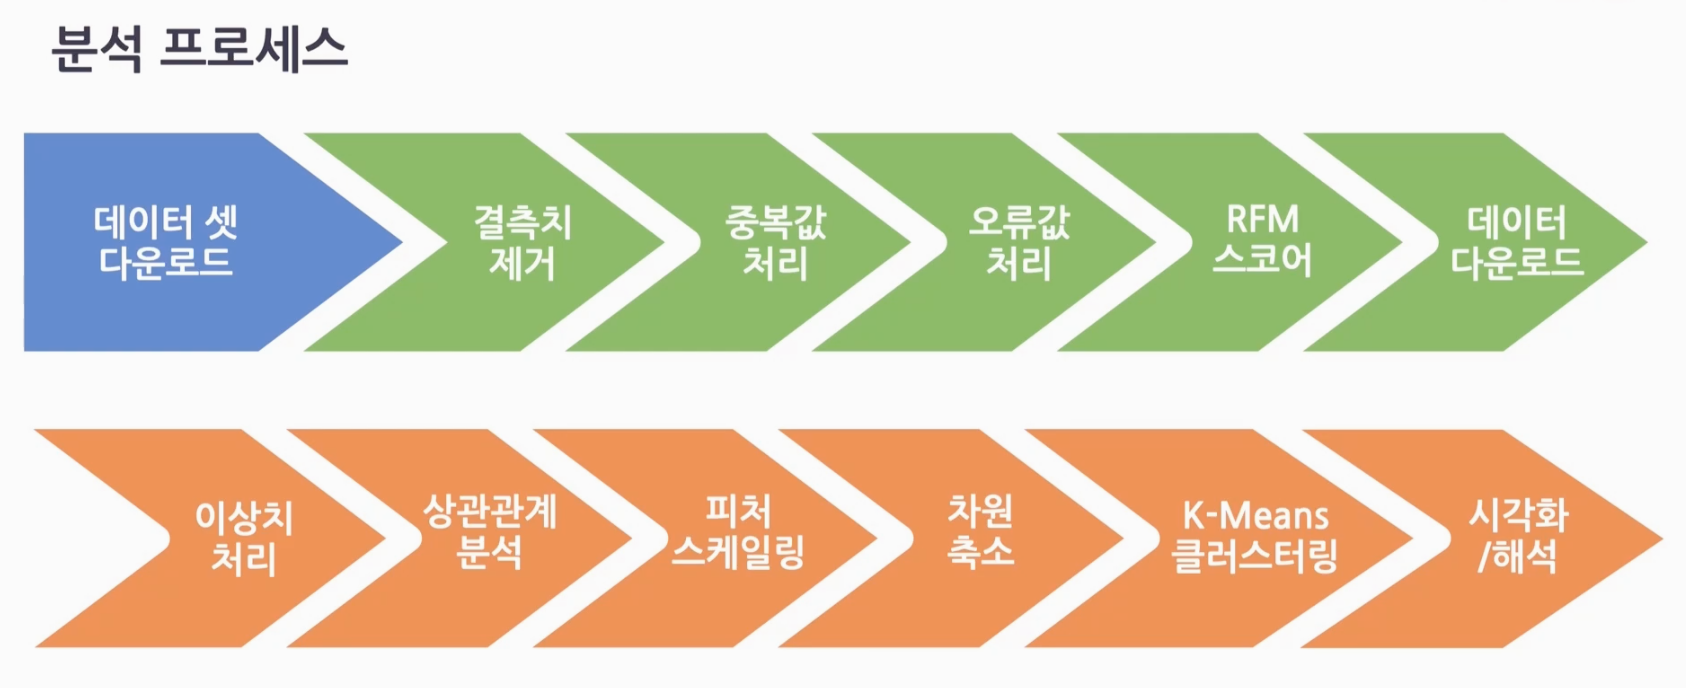

**SQL**
- 데이터 불러오기
- 데이터 전처리
    - 결측치 제거
    - 중복값 처리
    - 오류값 처리
- RFM 분석
- 추가 Feature 추출  

**Python**
- 이상 데이터 처리
- 변수간 상관관계 분석
- Feature 스케일링
- 차원 축소
- K-Means 클러스터링
- 시각화 및 결과 분석
    - 고객 세그먼테이션을 통한 인사이트와 전략

## 데이터 불러오기

Kaggle에 공개되어 있는 유명 E-Commerce Data로, UCI Machine Learning Repository에서 공개한 2010~2011년의 이커머스 데이터셋
https://www.kaggle.com/datasets/carrie1/ecommerce-data

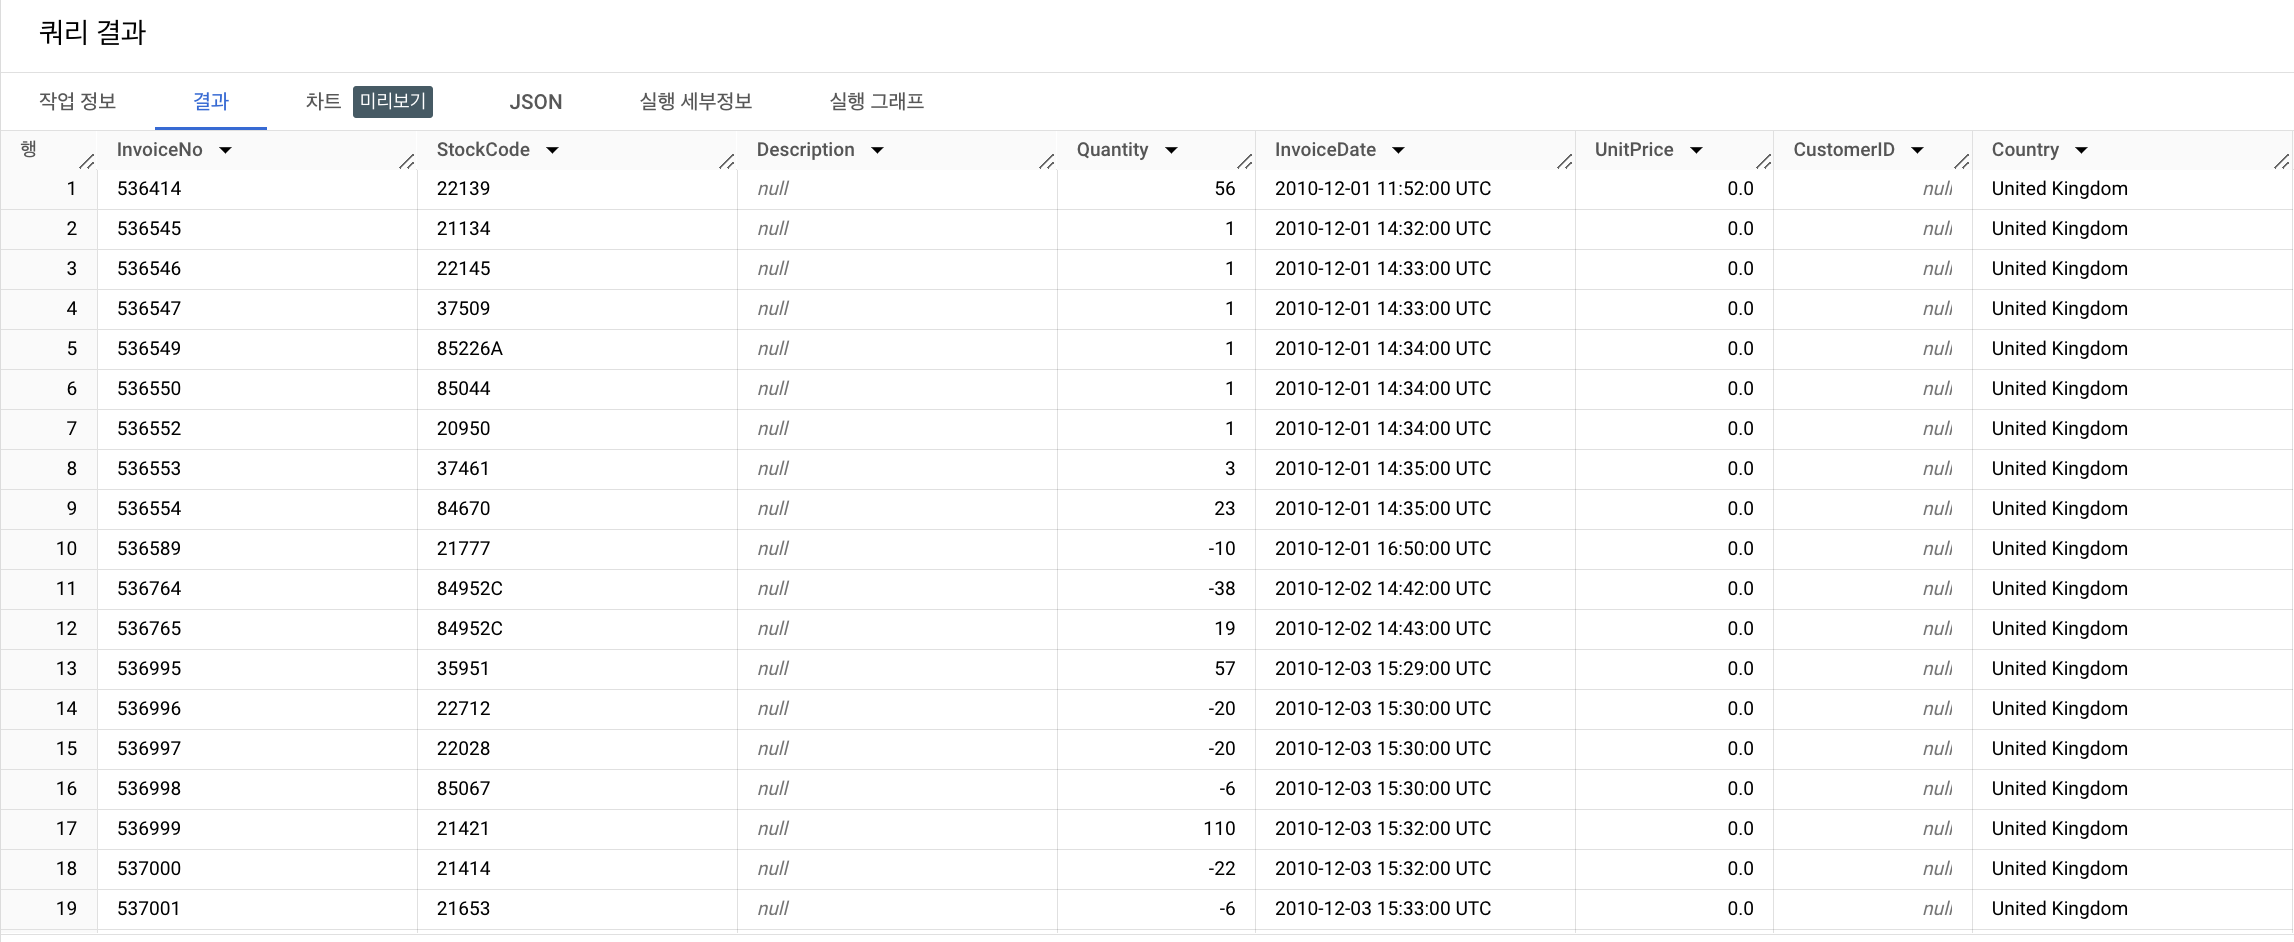

## 데이터 살펴보기

(1) 내가 우선 원하는 결과가 잘 나오는 쿼리인지 확인한 후  
(2) LIMIT을 제거하여  
(3) 전체 데이터셋에 적용

1. 10개의 행만 출력

In [ ]:
-- 10개 행만 추출
SELECT *
FROM project-rfm-240115.modulabs_project.data
LIMIT 10;

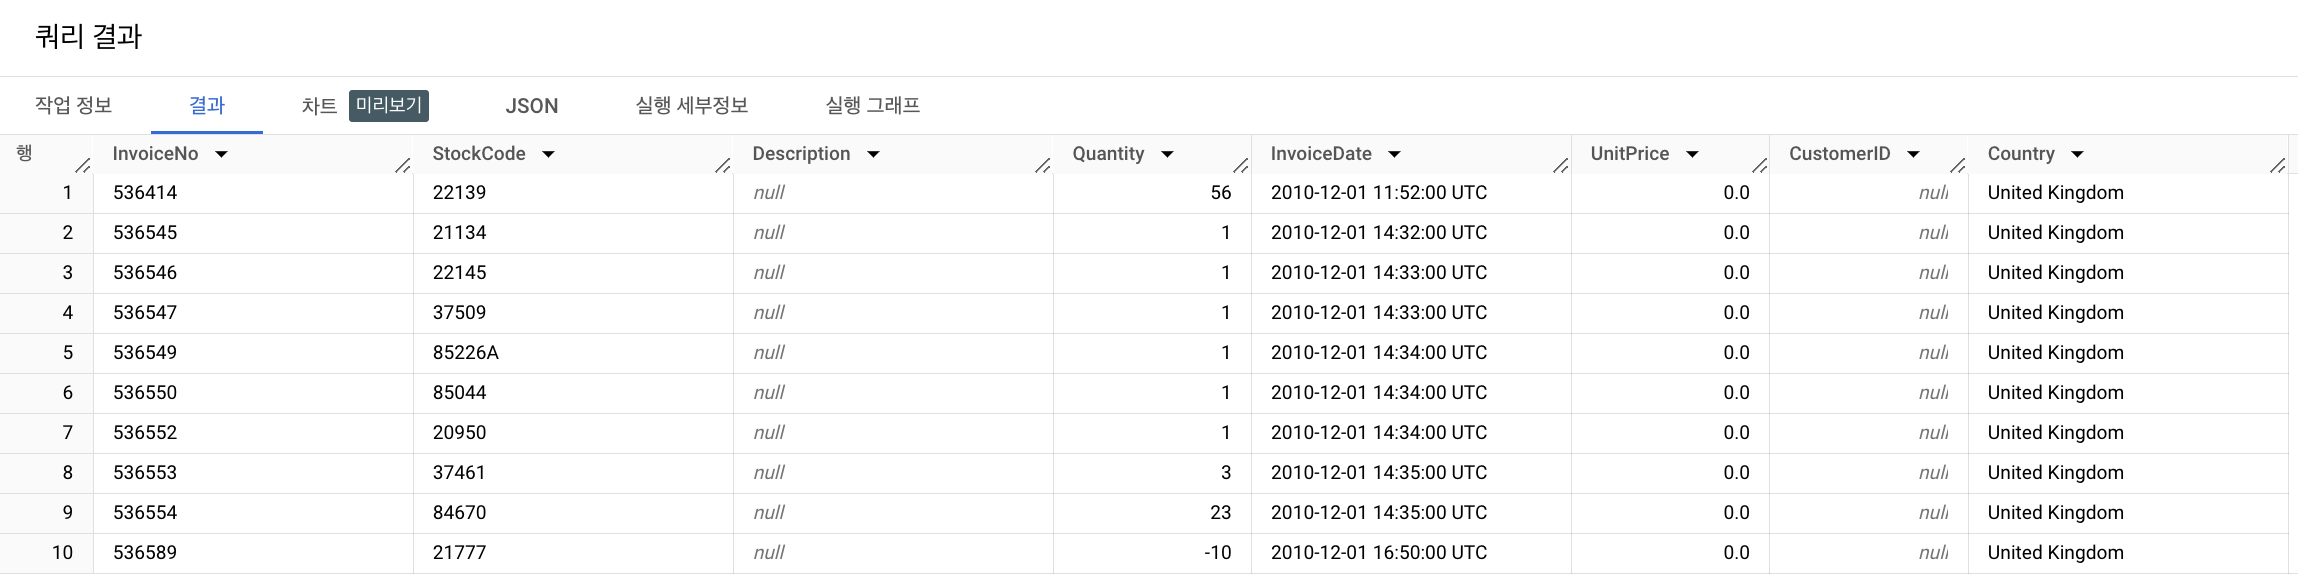

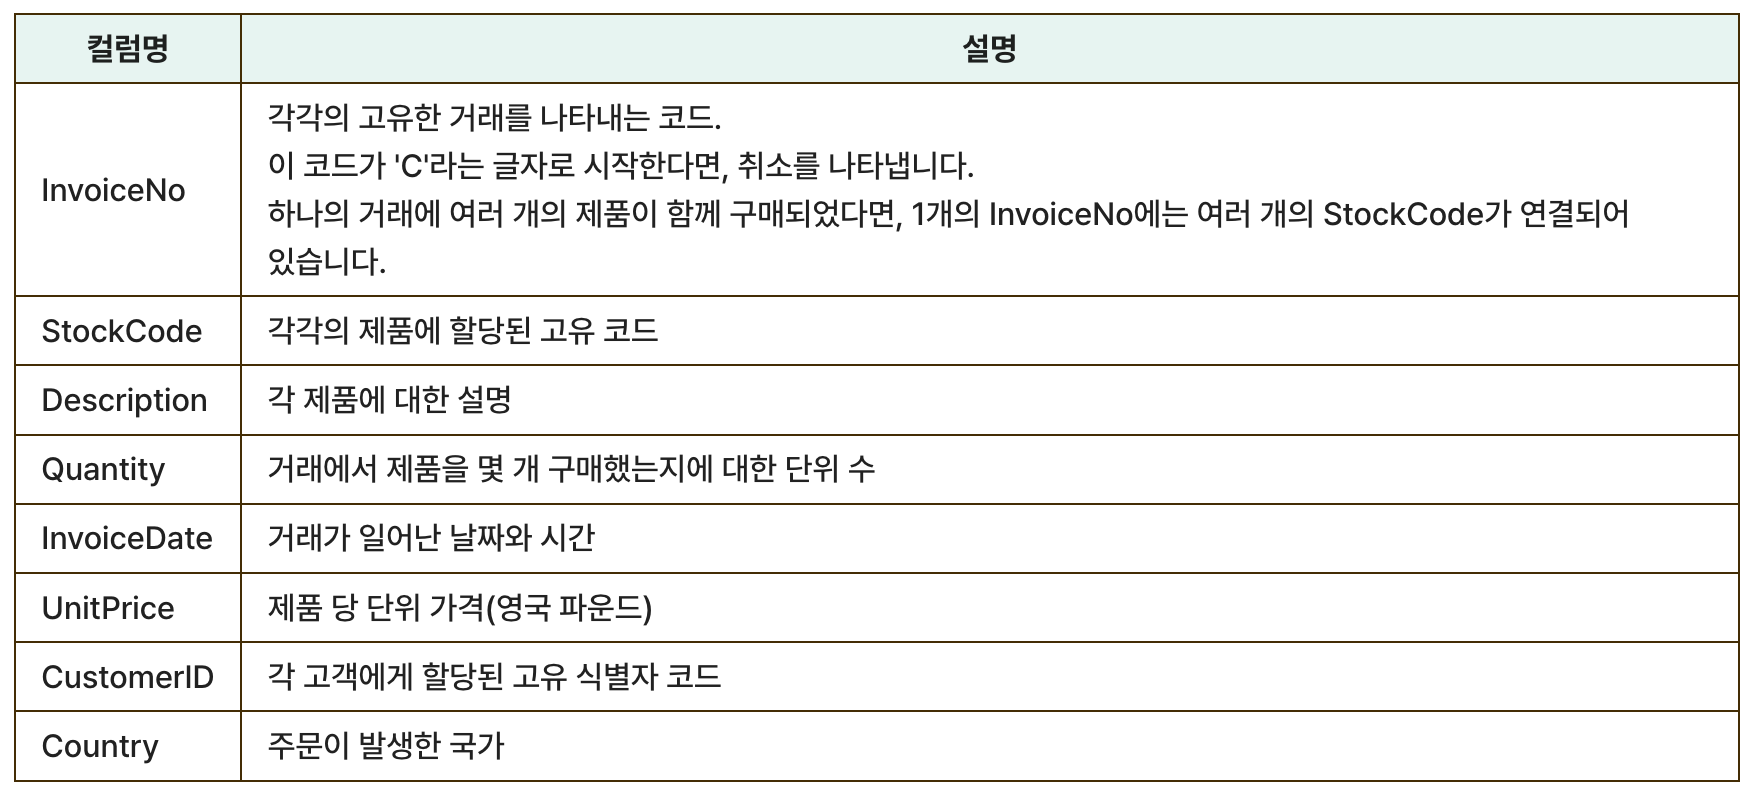

2. 전체 행

In [ ]:
-- 전체 행 추출
SELECT *
FROM project-rfm-240115.modulabs_project.data;

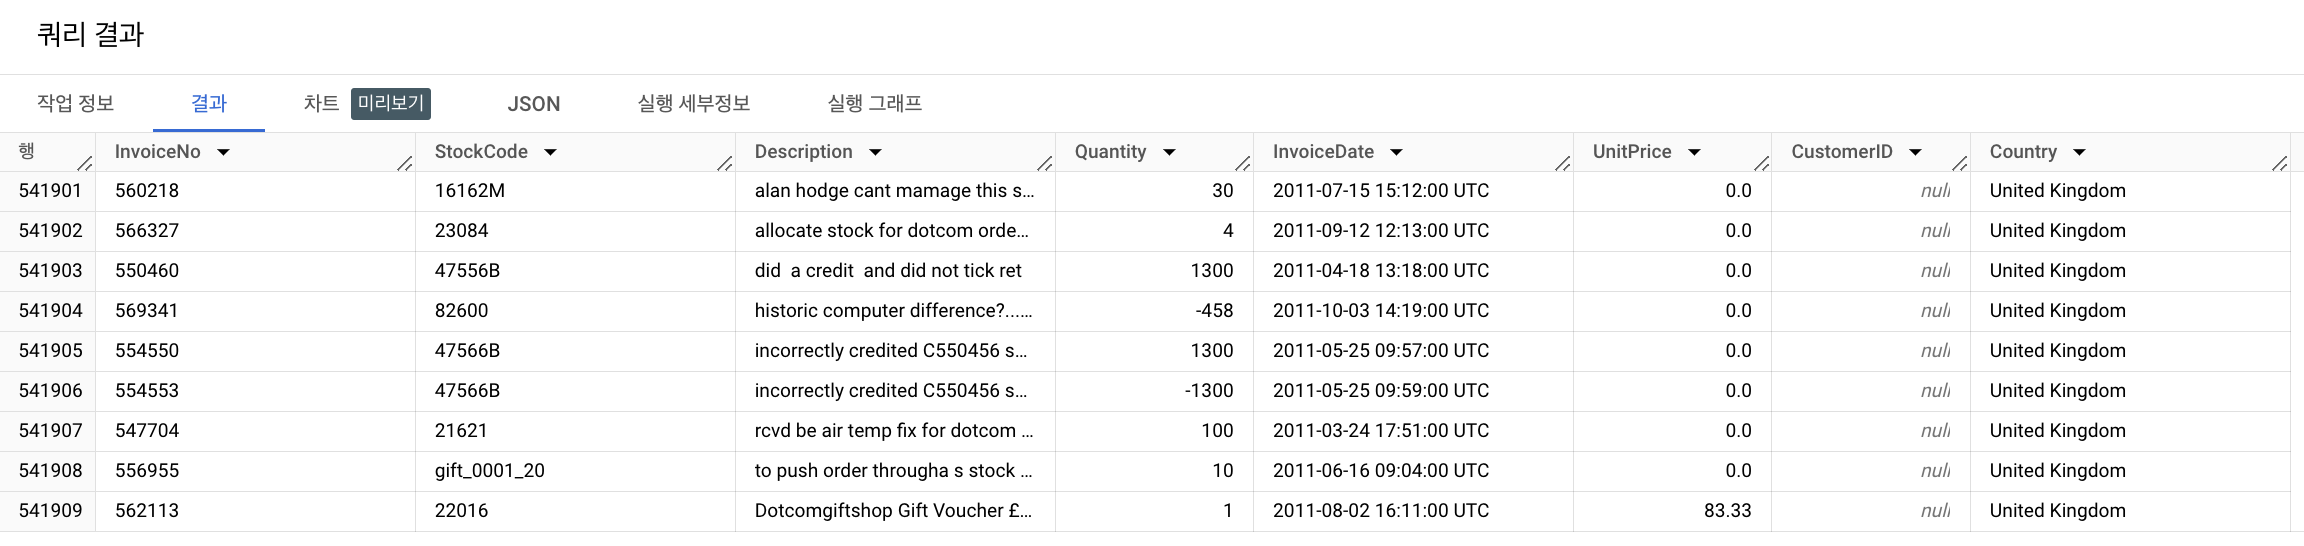

3. 데이터 수 세기

In [ ]:
-- 모든 컬럼에 대한 데이터 수
SELECT 
  COUNT(InvoiceNo) AS CNT_InvoiceNo,
  COUNT(StockCode) AS CNT_StockCode,
  COUNT(Description) AS CNT_Description,
  COUNT(Quantity) AS CNT_Quantity,
  COUNT(UnitPrice) AS CNT_UnitPrice,
  COUNT(CustomerID) AS CNT_CustomerID,
  COUNT(Country) AS CNT_Country
FROM project-rfm-240115.modulabs_project.data;

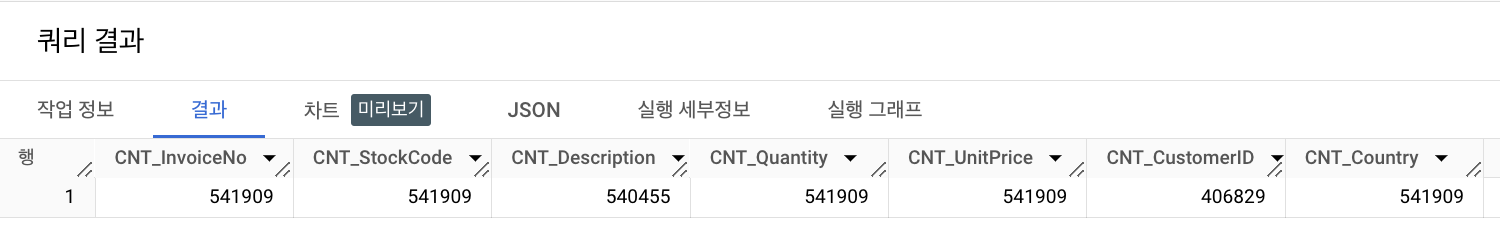

## 데이터 전처리

### 1. 결측치 처리

결측치:  데이터가 비어 있는 값

- 컬럼 별 누락된 값의 비율 계산 
    - 각 컬럼에 대해서 누락 값을 계산한 후, 계산된 누락 값을 UNION ALL을 통해 합치기

In [ ]:
-- 컬럼 별 누락된 값의 비율 계산
SELECT
    'InvoiceNo' AS InvoiceNo,
    ROUND(SUM(CASE WHEN InvoiceNo IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_I
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'StockCode' AS StockCode,
    ROUND(SUM(CASE WHEN StockCode IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_S
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'Description' AS Description,
    ROUND(SUM(CASE WHEN Description IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_D
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'Quantity' AS Quantity,
    ROUND(SUM(CASE WHEN Quantity IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_Q
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'InvoiceDate' AS InvoiceDate,
    ROUND(SUM(CASE WHEN InvoiceDate IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_In
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'UnitPrice' AS UnitPrice,
    ROUND(SUM(CASE WHEN UnitPrice IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_U
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'CustomerID' AS CustomerID,
    ROUND(SUM(CASE WHEN CustomerID IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_CID
FROM project-rfm-240115.modulabs_project.data
UNION ALL
SELECT
    'Country' AS Country,
    ROUND(SUM(CASE WHEN Country IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage_C
FROM project-rfm-240115.modulabs_project.data;


In [ ]:
-- 
SELECT column_name, ROUND((total - column_value) / total * 100, 2)
FROM
(
    SELECT 'InvoiceNo' AS column_name, COUNT(InvoiceNo) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'StockCode' AS column_name, COUNT(StockCode) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'Description' AS column_name, COUNT(Description) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'Quantity' AS column_name, COUNT(Quantity) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'InvoiceDate' AS column_name, COUNT(InvoiceDate) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'UnitPrice' AS column_name, COUNT(UnitPrice) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'CustomerID' AS column_name, COUNT(CustomerID) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data UNION ALL
    SELECT 'Country' AS column_name, COUNT(Country) AS column_value, COUNT(*) AS total FROM project-rfm-240115.modulabs_project.data
) AS column_data;

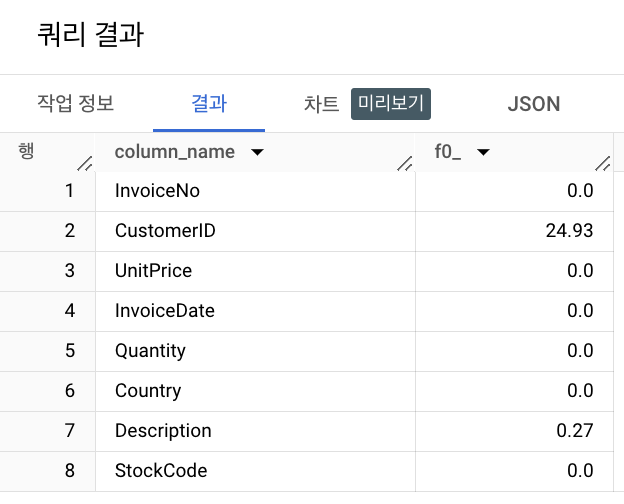

#### 결측치 처리 

**CustomerID**
- 고객을 클러스터링할 때 필수적인 정보이나, 결측치 비중이 25% 이다.
    - 큰 비율의 누락도니 값을 다른 값으로 대체하는 것은 분석에 상당한 편향을 주고 노이즈가 될 수 있다.
    - 또한, 이 프로젝트는 RFM 분석 기법에 따른 세그멘테이션이기 때문에 고객 식별자 데이터가 정확해야 한다.
        - 데이터 편향: 데이터가 특성 경향을 가지고 있어 전체적인 분석이나 결과가 왜곡되는 현상
        - 데이터 노이즈: 데이터에 관련 없는 정보가 포함되어 있어 데이터의 지링 저하되고 분석의 정확도가 떨어지는 것
- 결측치가 있는 **CustomerID**가 있는 행을 제거하는 것이 합리적인 접근 방법으로 보인다.

**Description**
- 결측치가 비교적 적으나, 같은 제품이 항상 같은 상세 설명을 가지고 있지 않다는 데이터의 일관성 문제가 발견되었다.
    - 'StockCode = 85123A' 제품을 지징하는 설명이 4개 모두 다르다.
    - 이는 제품 설명이 일관적으로 기록되지 않은 오류로 해석할 수 있다.
    - 일관성 결여를 고려할 때 StockCode를 기반으로 누락된 설명을 대체하는 것은 신회할 수 없을 가능성이 있다.

In [ ]:
-- Description
SELECT DISTINCT Description
FROM project-rfm-240115.modulabs_project.data
WHERE  StockCode = '85123A';

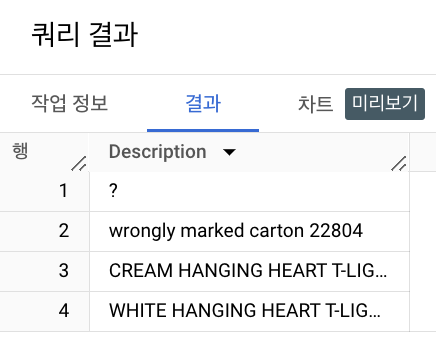

- 결측치 비율이 낮으며, 데이터의 일관성 문제가 후속 분석 과정에 영향을 주지 않게 하기 위해 누락된 설명이 있는 행을 제거하는 것이 합리적인 접근 방법으로 보인다.

In [ ]:
DELETE FROM project-rfm-240115.modulabs_project.data
WHERE CustomerID IS NULL;

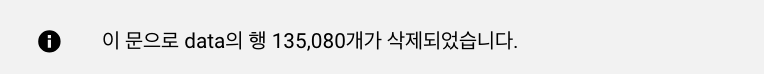

### 2. 중복값 처리

중복값: 데이터셋에서 똑같은 정보를 가진 반복된 행

1) 중복값 확인

In [ ]:
SELECT COUNT(*) AS DuplicateRowCount
FROM (
    SELECT InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, COUNT(*) AS RowCount
    FROM project-rfm-240115.modulabs_project.data
    GROUP BY InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
    HAVING COUNT(*) > 1
);

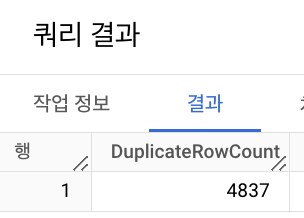

2) 중복값 처리   
프로젝트의 맥락에서 완전히 동일한 행들, 특히 동일한 거래 시간을 포함한 동일한 행은 데이터 오류일 가능성이 높다.  
이러한 종복 행을 유지하면 분석 결과에 영향을 줄 수 있다.  
데이터셋에서 완전히 동일한 중복 행들을 제거할 것이다.

In [ ]:
-- 중복값 제거
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.data
AS
SELECT DISTINCT *
FROM project-rfm-240115.modulabs_project.data;

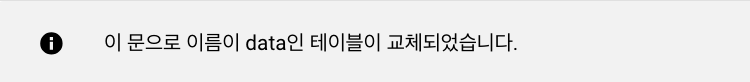

In [ ]:
-- 처리 후 남은 데이터 행의 개수
SELECT COUNT(*)
FROM project-rfm-240115.modulabs_project.data;

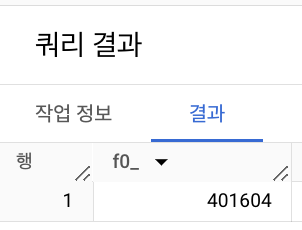

### 3. 오류값 처리
컬럼 단위로 데이터를 살펴보면서 클렝징이 필요한 값들이 있는지 살펴보기

1) InvoiceNo

In [ ]:
-- InvoiceNo Unique
SELECT DISTINCT InvoiceNo
FROM project-rfm-240115.modulabs_project.data;

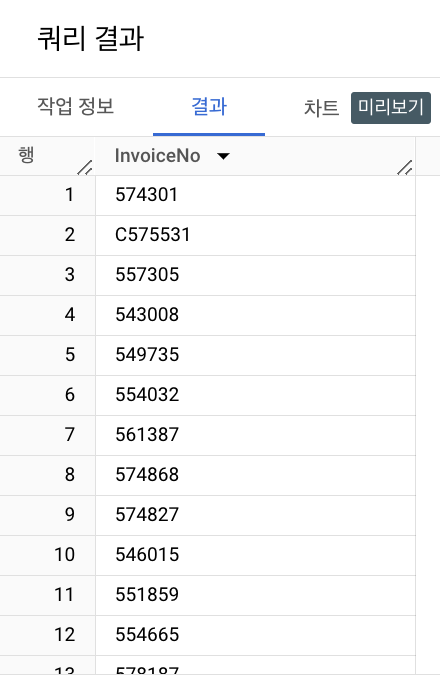

총: 22,190개

- 데이터를 살펴보면 몇 개의 InvoiceNo는 'C'로 시작한다는 것을 알 수 있다.
    - 'C': 취소한 거래
    - 고객 행동과 제품 선호도에 대한 이해를 높이기 위해서는 취소된 거래들도 고려해야 한다.
- 'C'로 시작하는 행 필터링

In [ ]:
-- InvoiceNo C Filtering
SELECT *
FROM project-rfm-240115.modulabs_project.data
WHERE InvoiceNo LIKE "%C%"
LIMIT 100;

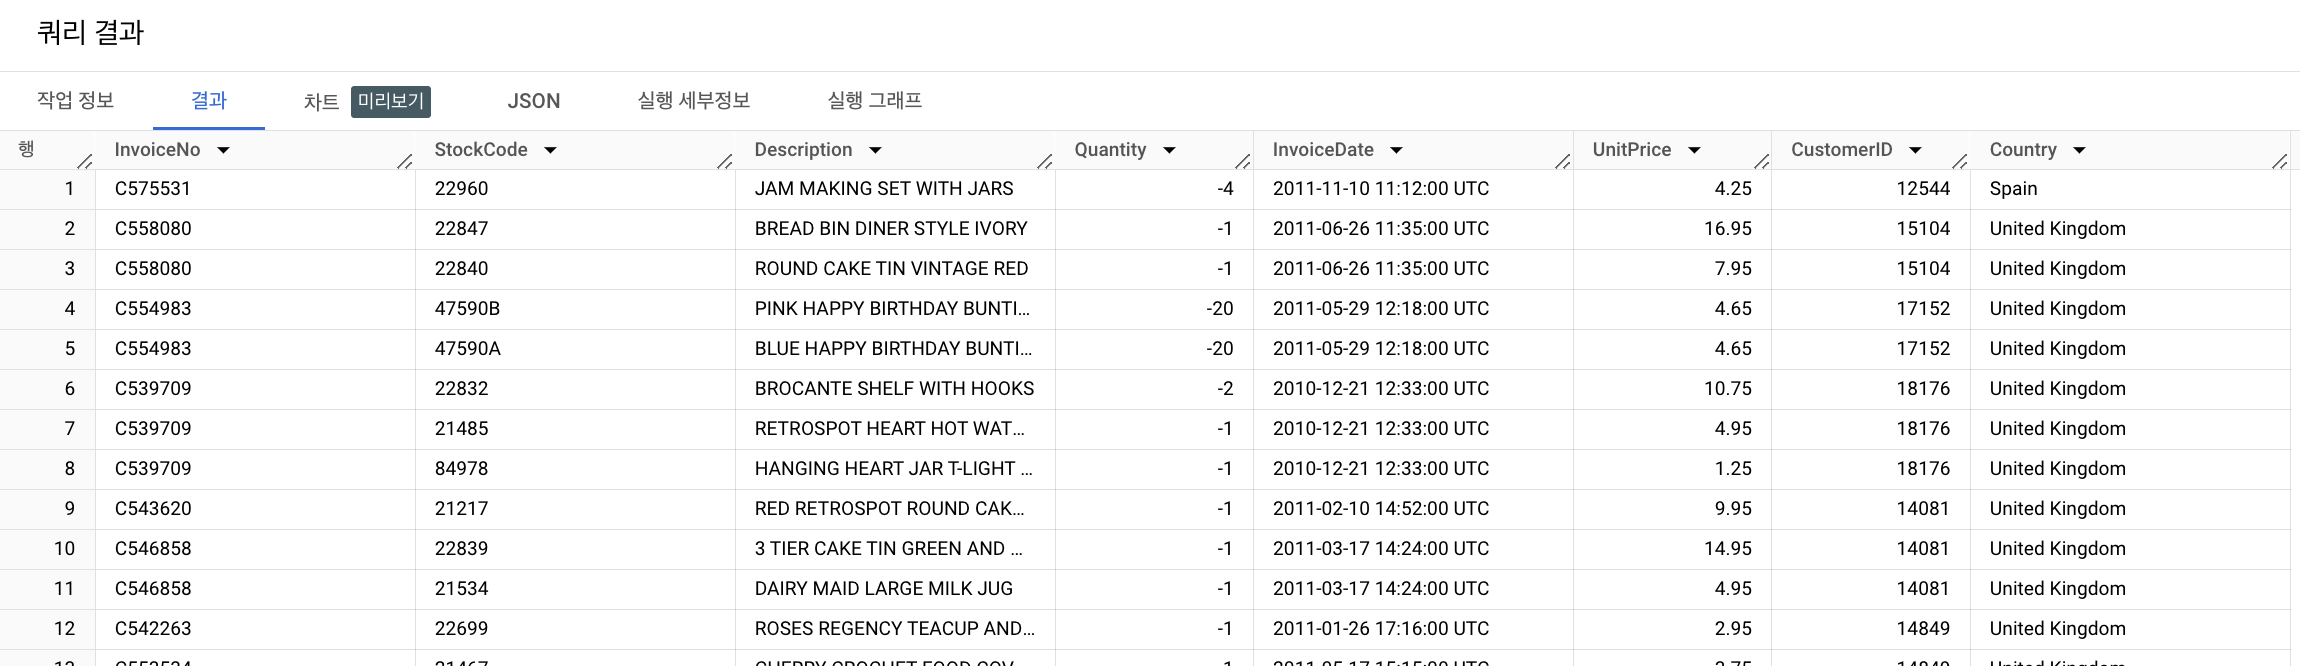
데이터를 살펴보면 InvoiceNo 컬럼에서 'C'가 붙은 취소 건들을 Quantity가 음수인 것을 알 수 있다.

- 구매 건 상태가 Canceled인 데이터 비율(%)

In [ ]:
-- Canceled Percentage
SELECT 
  ROUND(
    (SUM(CASE WHEN InvoiceNo LIKE '%C%' THEN 1 ELSE 0 END) / COUNT(*)) * 100, 1
  ) AS CanceledPercentage
FROM project-rfm-240115.modulabs_project.data;

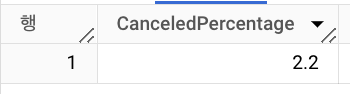

- 취소를 많이 한 제품들의 가격대가 높았는지, 또는 거래 지역이 특정 지역에 몰려있는지 살펴보았지만 그런 경향성을 크게 보이지 않았다.
    - Country는 취소 여부 상관없이 United Kingdom에 밀집되어 있었다.   


- InvoiceNo 추가 처리
    - 프로젝트 목표가 고객들의 구매 최신성, 구매 빈도, 구매 금액에 따라 세그멘테이션하는 것이기 때문에, 고객의 취소 패턴을 이해하는 것이 중요할 것이다.
    - 취소된 거래에 공통점이 있는지 살펴볼 수 있을 것이고, 추천될 가능성이 높은 제품을 찾아서 문제를 진단할 수 있다.
        - 취소된 거래 데이터는 유지하되, 명확하게 표시하여 추가 분석을 용이하게 만들어주는 것도 전략 중 하나이다.
     

2) StockCode

In [ ]:
-- Unique StockCode
SELECT DISTINCT StockCode
FROM project-rfm-240115.modulabs_project.data;

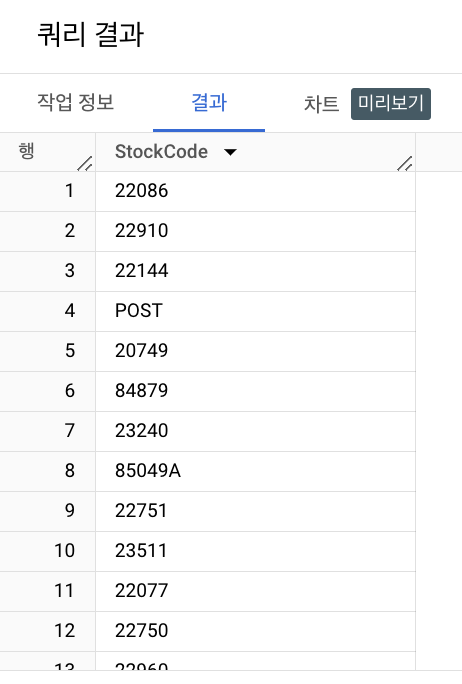

총: 3,684개

In [ ]:
-- StockCode 등장 빈도 상위 10개만 출력
SELECT StockCode, COUNT(*) AS sell_cnt
FROM project-rfm-240115.modulabs_project.data
GROUP BY StockCode
ORDER BY sell_cnt DESC
LIMIT 10;

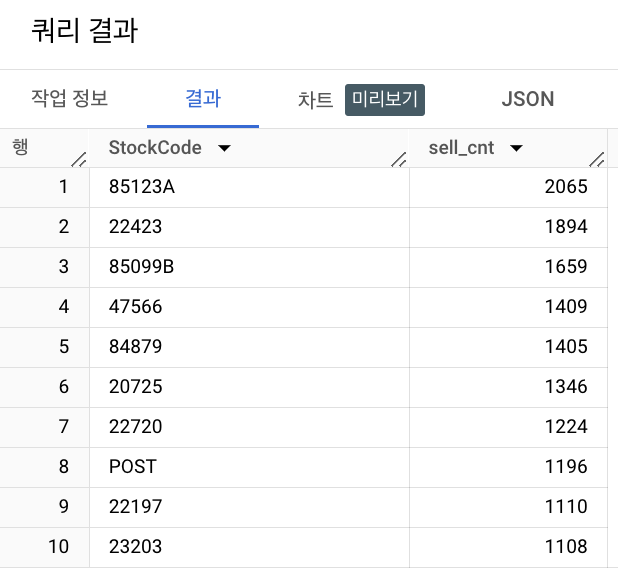
가장 판매가 많이 일어난 상위 10개의 제품 코드를 살펴보면, 고객들이 자주 구매하는 인기 제품군이나 카테고리에 대한 인사이트를 얻을 수 있다. 

- 제품 코드는 대부분 5 ~ 6 자리의 숫자와 문자 조합으로 구성되어 있다.
- POST와 같은 몇 가지 이상한 코드도 있었다.
    - 이러한 현상은 실제 제품보다는 서비스나 배송비 같은 형태를 코드로 남긴 것일 수도 있다.
    - 현재 프로젝트는 고객의 제품 구매에 초점이 맞춰져 있기 때문에 이러한 값들은 제거하는 것이 좋을 거 같다. 

- 이상치 제거
    - StockCode의 문자열 내 숫자 길이를 구하기

In [ ]:
-- 문자열 내 숫자길이
WITH UniqueStockCodes AS (
  SELECT DISTINCT StockCode
  FROM project-rfm-240115.modulabs_project.data
)
SELECT
  LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count,
  COUNT(*) AS stock_cnt
FROM UniqueStockCodes
GROUP BY number_count
ORDER BY stock_cnt DESC;

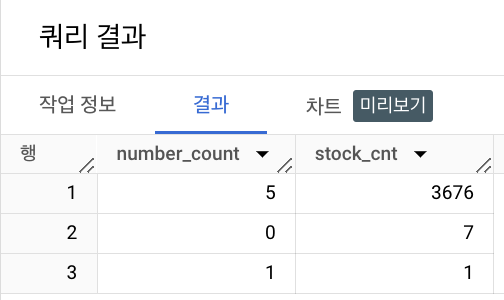

출력 결과
- StockCode에 5개의 숫자들이 포함되어 있다.
    - 숫자가 0개인 코드: 7개, 숫자가 1개인 코드: 1개

In [ ]:
-- 숫자가 0 ~ 1개인 코드 확인
SELECT DISTINCT StockCode, number_count
FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM project-rfm-240115.modulabs_project.data
) 
WHERE number_count <= 1;

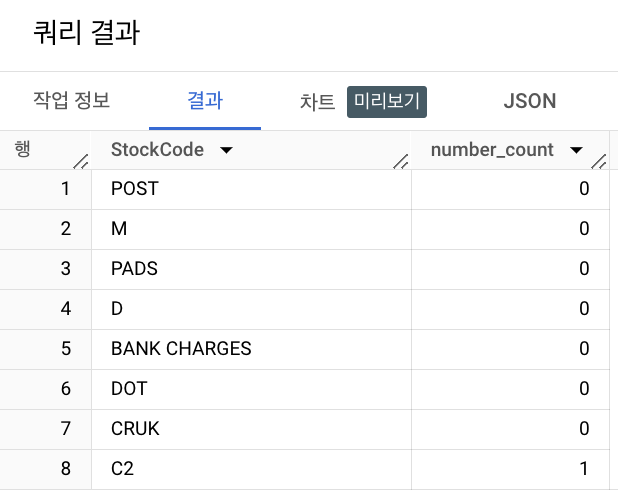

In [ ]:
-- 해당 코드 값들을 가지고 있는 데이터수의 비율
WITH StockCodeCounts AS (
  SELECT DISTINCT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM project-rfm-240115.modulabs_project.data
)

SELECT 
  COUNT(*),
  ROUND(
    (COUNT(*) / (SELECT COUNT(*) FROM StockCodeCounts)) * 100, 2
  ) AS Ratio
FROM StockCodeCounts
WHERE number_count <= 1;

In [ ]:
WITH StockCodeCounts AS (
  SELECT DISTINCT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM project-rfm-240115.modulabs_project.data
)

SELECT 
  ROUND(
    (COUNT(*) / (SELECT COUNT(*) FROM StockCodeCounts)) * 100, 2
  ) AS Ratio
FROM StockCodeCounts
WHERE number_count <= 1;


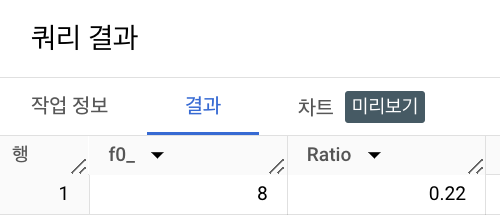

0.22% 비율로 데이터가 일반적인 형식에서 벗어난 값을 가지고 있다.
- BANK CAHRGES, POST 등 제품과 관련되지 않는 거래 기록도 보인다.
- 이런 StockCode가 포함된 기록은 데이터셋에서 제외하도록 한다.

In [ ]:
-- 제품과 관련되지 않은 거래 기록을 제거
DELETE FROM project-rfm-240115.modulabs_project.data
WHERE StockCode IN (
  SELECT DISTINCT StockCode
  FROM (
    WITH StockCodeCounts AS (
      SELECT DISTINCT StockCode,
        LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
      FROM project-rfm-240115.modulabs_project.data
    )

    SELECT DISTINCT StockCode
    FROM StockCodeCounts
    WHERE number_count <= 1
  )
);

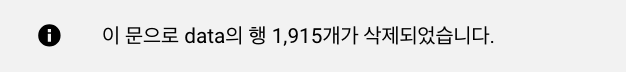

3) Description

In [ ]:
-- Desctiption 출현 빈드
SELECT Description, COUNT(*) AS description_cnt
FROM project-rfm-240115.modulabs_project.data
GROUP BY Description
LIMIT 30;

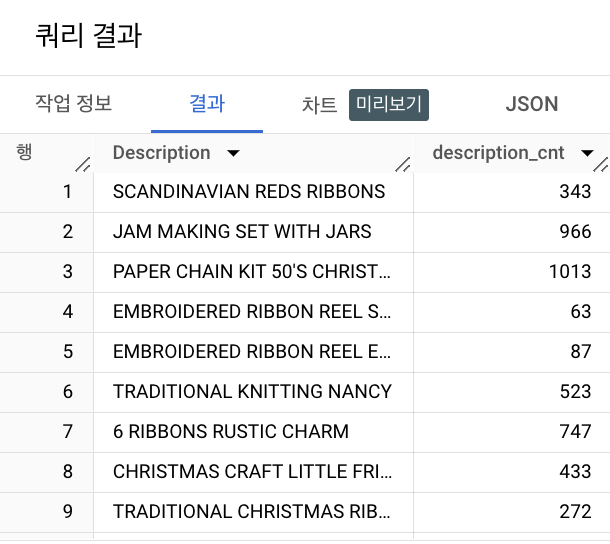

In [ ]:
-- 대소문자 혼합된 Description 확인
SELECT DISTINCT Description
FROM project-rfm-240115.modulabs_project.data
WHERE REGEXP_CONTAINS(Description, r'[a-z]');

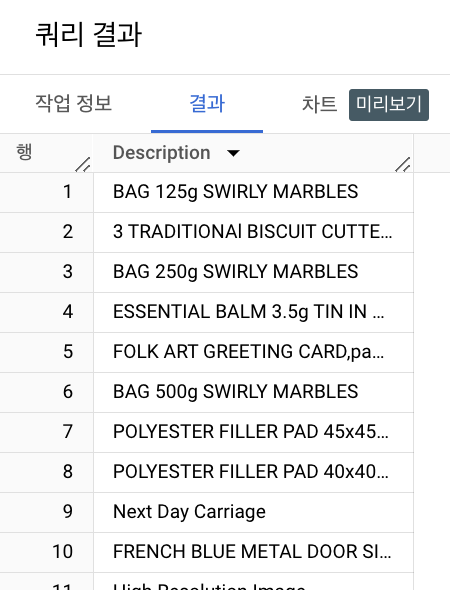

총: 19개

출력 결과
- 사이즈(cm), 무게(g) 등 단위를 나타내는 설명 포함
- "Next Day Carriage", "High Resolution Image"와 같이 일부 항목들처럼 실제 제품에 대한 Description이 아닌 것도 있는 것을 알 수 있다.
    - 실체 제품 정보와 과련이 없어 보이며, 다른 유형의 정보나 서비스 세부사항을 나타내는 것일 수도 있다.     
    
처리 방법
- 서비스 관련 정보를 포함하는 행 제거

In [ ]:
-- 서비스 관련 정보 포함 행 제거
DELETE
FROM project-rfm-240115.modulabs_project.data
WHERE Description LIKE '%Next Day Carriage%'
   OR Description LIKE '%High Resolution Image%';

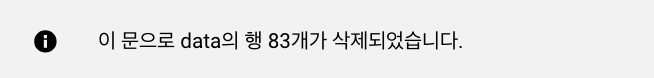

- 대소문자를 혼합해서 사용하는 경우, 대문자로 표준화하여 데이터 셋에 전체 일관성 유지

In [ ]:
-- 대문자로 표준화
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.data AS
SELECT
  * EXCEPT (Description),
  UPPER(Description) AS Description 
FROM project-rfm-240115.modulabs_project.data;

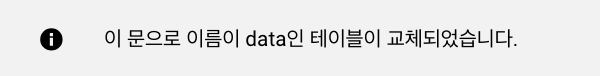

4) UnitPrice

In [ ]:
-- UnitPrice 오약 통계량
SELECT 
  MIN(UnitPrice) AS min_price, 
  MAX(UnitPrice) AS max_price, 
  AVG(UnitPrice) AS avg_price
FROM project-rfm-240115.modulabs_project.data;

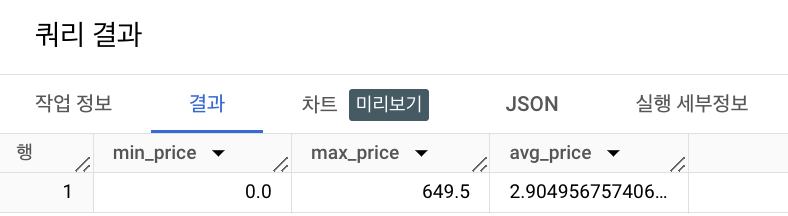

최소 단위 가격: 0
최대 단위 가격: 649.5
평균 단위 가격: 2.9049567574060684

- 단가가 0인 데이터가 존재한다.
    - 이는 제품이 무료이거나 데이터 오류일 수도 있다.

In [ ]:
-- 단가가 0원인 거래의 개수, 구매 수량의 요약 통계량
SELECT 
  COUNT(Quantity) AS cnt_quantity, 
  MIN(Quantity) AS min_quantity, 
  MAX(Quantity) AS max_quantity,
  AVG(Quantity) AS avg_quantity,
FROM project-rfm-240115.modulabs_project.data
WHERE UnitPrice = 0;

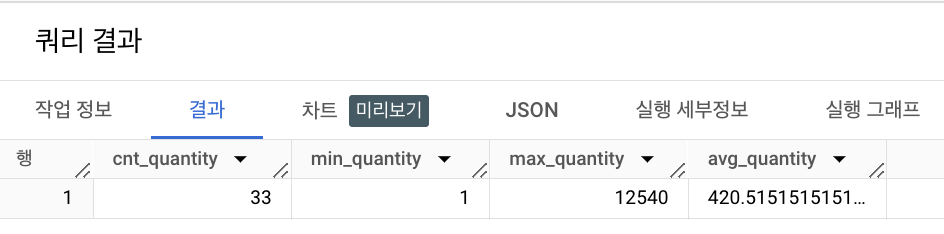

UnitPrice가 0인 행: 33개
구매 수량 최소: 1개
구매 수량 최대: 12,540개

- 구매 수량이 굉장한 큰 편차를 가진다.
- 데이터의 수가 적은 걸보니 무료 제품보다는 데이터 오류일 가성이 높을 거 가ㅌㅌ다.
- UnitPrice = 0을 제거하고 일관된 데이터셋을 유지한다.

In [ ]:
-- UnitPrice = 0 데이터 제거
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.data AS 
SELECT *
FROM project-rfm-240115.modulabs_project.data
WHERE UnitPrice != 0;

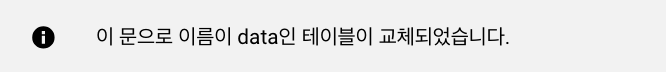

나머지 컬럼들은 크게 오류값을 처리할 것이 없다.

## RFM Score

### Recency

고객이 얼마나 최근에 구매를 했는지에 중점을 둔다.
- 마지막 구매일로부터 현재까지 경과한 일수 계산
    - 낮은 값일수록 최근에 구매를 했음을 의미하며, 제품이나 서비스에 더 관심을 보인다 예측할 수 있다.
    - 오랜 시간 구매하지 않았던 고객을 발견하고, 다시 제품과 서비스로 불러들이기 위한 마케팅 전략을 맞춤화해볼 수 있다.

In [ ]:
-- InvoiceDate를 'YYYY-MM-DD' 형태로 변환
SELECT 
  DATE(InvoiceDate) AS InvoiceDay,
  *
FROM project-rfm-240115.modulabs_project.data;

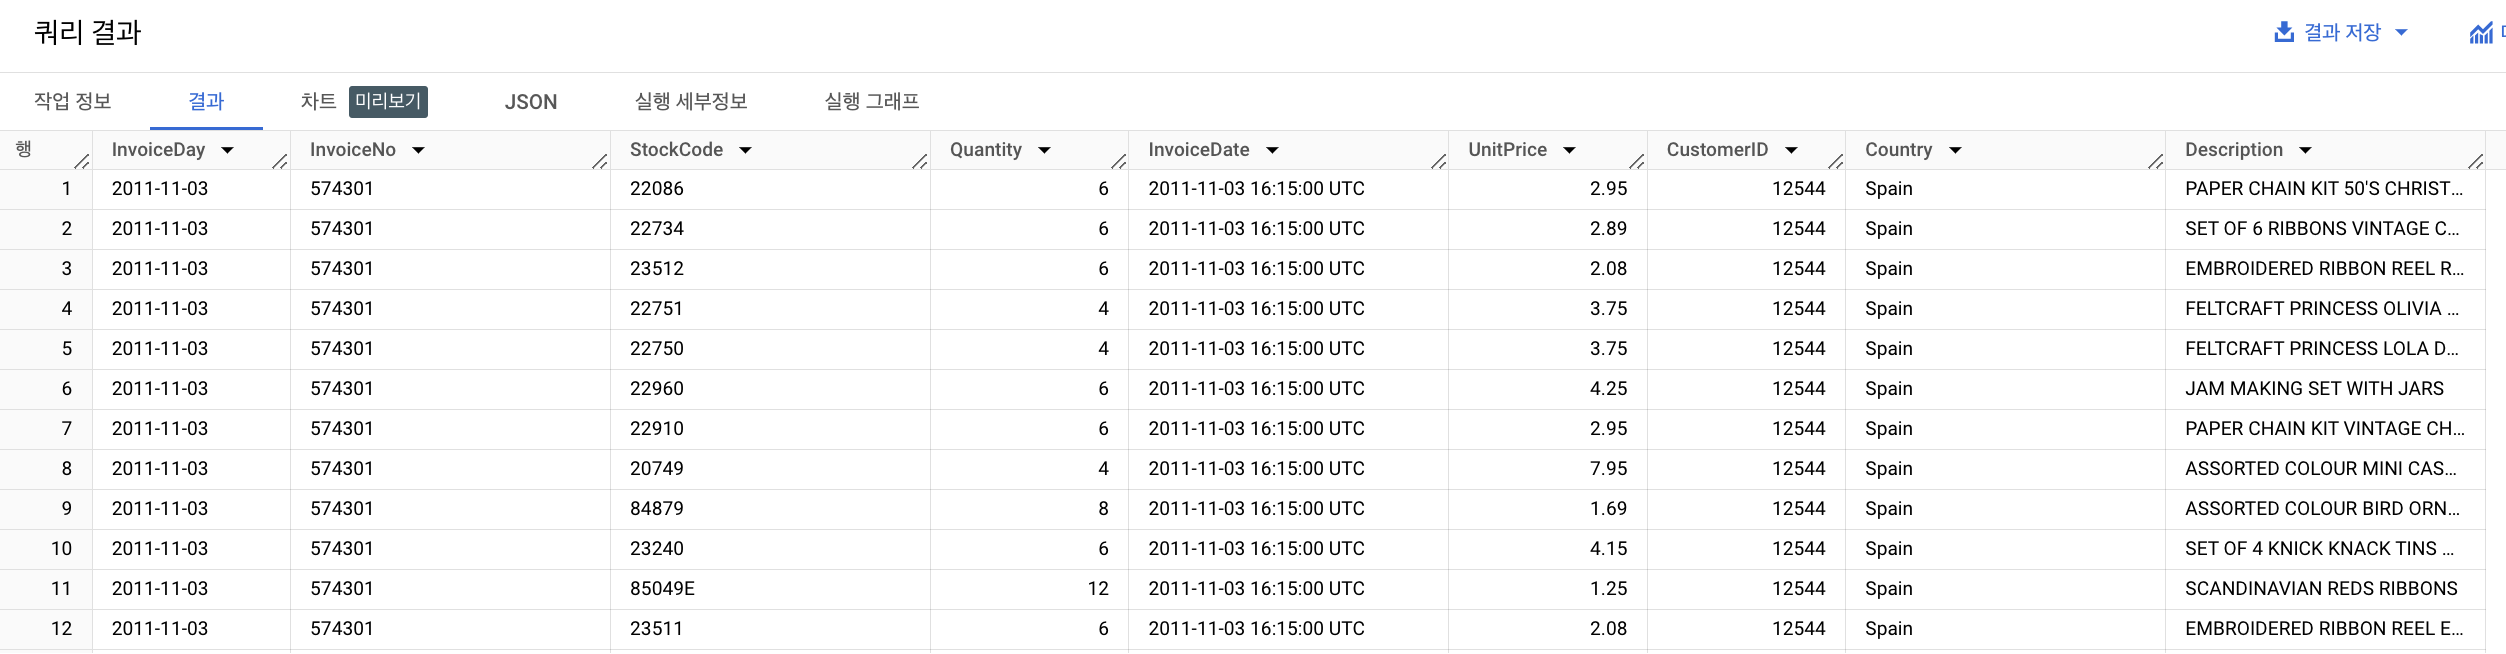

In [ ]:
-- 최근 구매 일자
SELECT 
  MAX(InvoiceDate) AS most_recent_date, 
  DATE(MAX(InvoiceDate)) AS InvoiceDay,
FROM project-rfm-240115.modulabs_project.data;

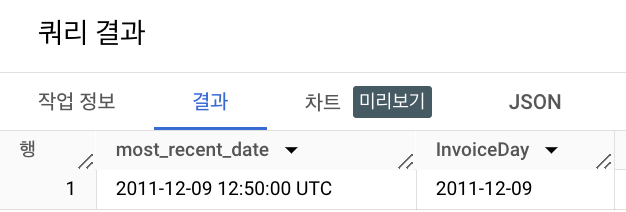

In [ ]:
-- 유저별 가장 큰 InvoiceDay를 찾아서 가장 최근 구매일로 저장
SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
FROM project-rfm-240115.modulabs_project.data
GROUP BY CustomerID;

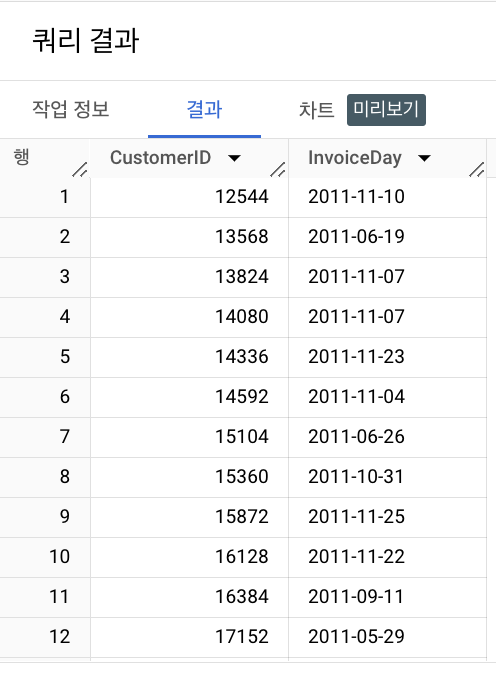

In [ ]:
-- 가장 최근 일자(most_recent_date)와 유저별 마지막 구매일(InvoiceDay)간의 차이를 계산
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
);

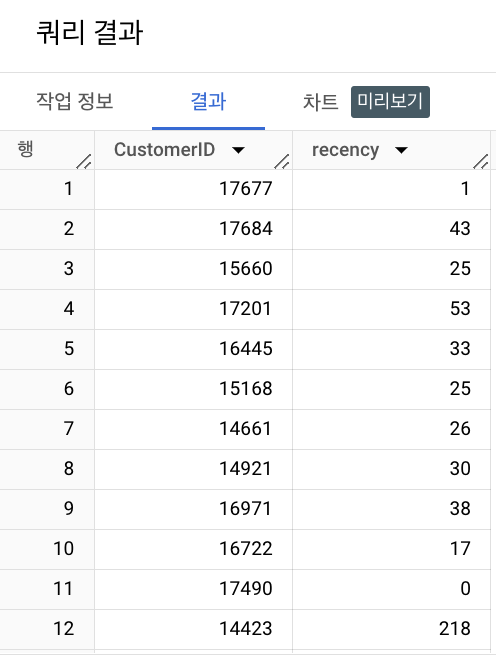

- MAX(InvoiceDay) OVER () - InvoiceDay : 각 고객(CustomerID)의 각 구매일(InvoiceDay)과 전체 데이터셋에서의 마지막 구매일(MAX(InvoiceDay)) 간의 차이를 계산
- EXTRACT(DAY FROM …) : 여기에서 EXTRACT 함수는 위에서 계산된 날짜 차이에서 일(DAY) 부분만을 추출합니다. 즉 각 고객의 최근 구매일로부터 해당 구매 건의 구매일부터의 날짜 차이를 계산하는 함수

In [ ]:
-- 테이블 저장
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.user_r AS
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
);

-- 테이블 확인
SELECT *
FROM project-rfm-240115.modulabs_project.user_r

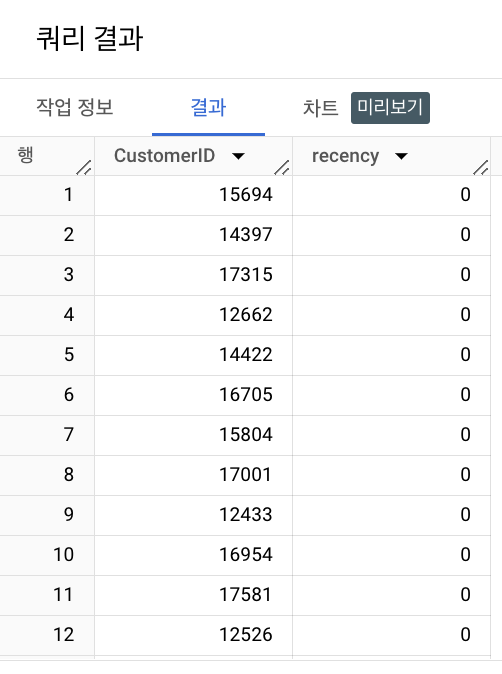

### Frequncy

고객의 구매 빈도 또는 참여 빈도에 초점을 맞춘다.

- 전체 거래 건수로 계산을 할 수도 있고, 구매한 아이템의 수량을 합하여 계산할 수도 있다.

1) 전체 거래 건수 계산

In [ ]:
-- 고객마다 고유한 InvoiceNO의 수
SELECT
  CustomerID,
  COUNT(DISTINCT InvoiceNo) AS purchase_cnt
FROM project-rfm-240115.modulabs_project.data
GROUP BY CustomerID;

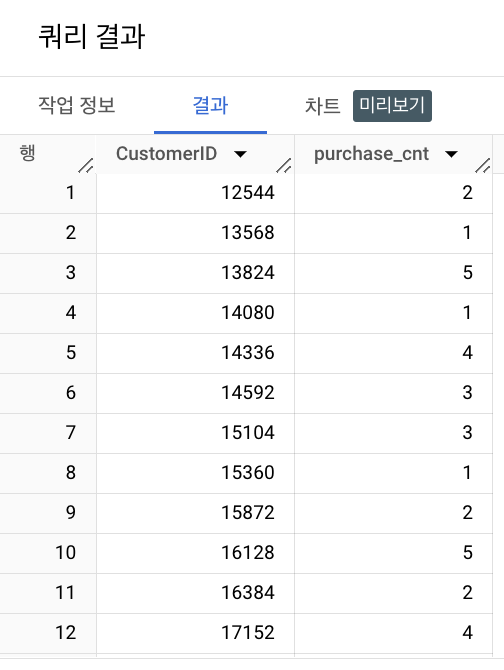

2) 구매한 아이템의 총 수량 계산

In [ ]:
-- 각 고객별 구매한 아이템의 총 수량
SELECT
  CustomerID,
  SUM(Quantity) AS item_cnt
FROM project-rfm-240115.modulabs_project.data
GROUP BY CustomerID;

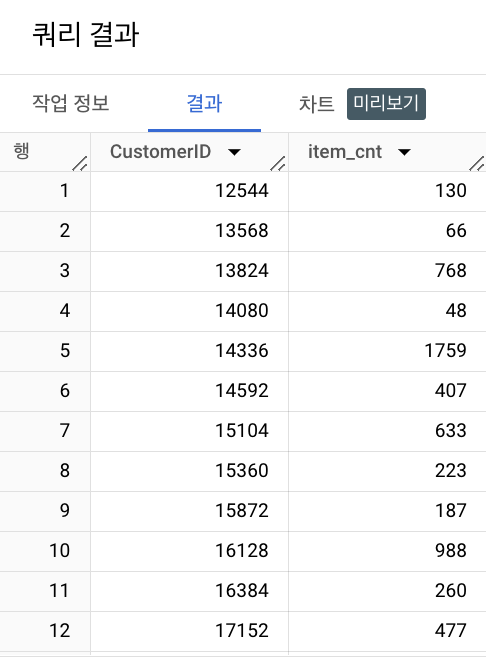

In [ ]:
-- 테이블 저장
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.user_rf AS

-- (1) 전체 거래 건수 계산
WITH purchase_cnt AS ( 
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS purchase_cnt
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
),

-- (2) 구매한 아이템 총 수량 계산
item_cnt AS (
  SELECT
    CustomerID,
    SUM(Quantity) AS item_cnt
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
)

-- 기존의 user_r에 (1)과 (2)를 통합
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN project-rfm-240115.modulabs_project.user_r AS ur
  ON pc.CustomerID = ur.CustomerID;
    

-- 테이블 확인
SELECT * 
FROM project-rfm-240115.modulabs_project.user_rf

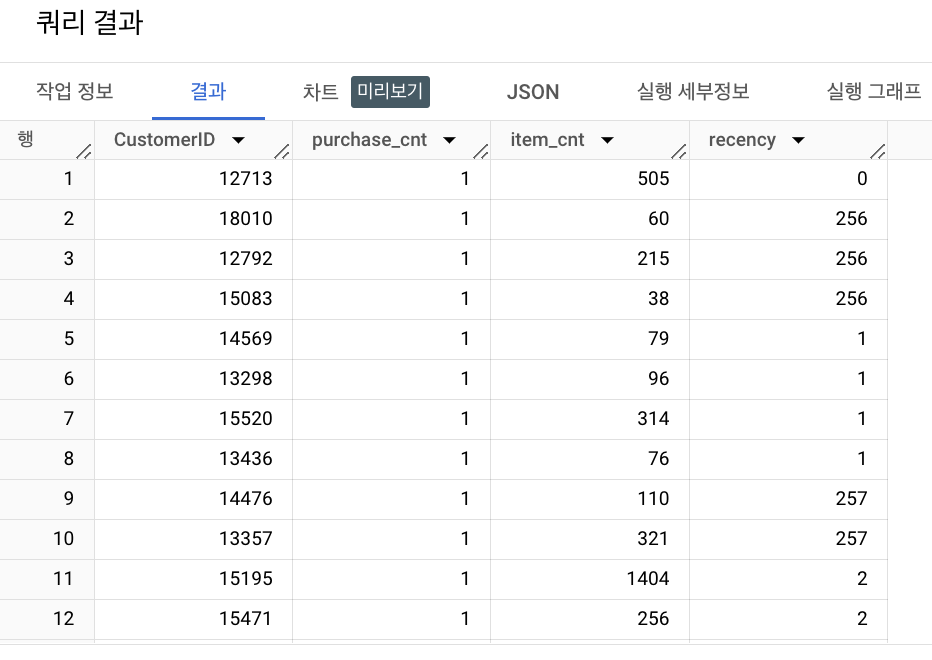

### Monetary

고객이 지불한 총 금액에 초점을 맞춘다.
- 총 지출액을 계산할 수도 있고, 거래당 평균 거래 금액을 거래할 수도 있다.
- 결제한 총 금액이 높은 고객을 찾는 것도 좋지만, 한 번에 많이 구매하는 고객들을 찾는 것도 굉장히 중요하다.
    - 결제 금액은 낮지만 구매를 자주하는 고객과, 한 번 결제할 때 큰 금액을 결제하는 고객은 분명 특성이나 행동 패턴이 다를 것이다.

1) 고객별 총 지출액 계산

In [ ]:
-- 고객별 총 지출액 계산
SELECT
  CustomerID,
  ROUND(SUM(Quantity * UnitPrice), 1) AS user_total
FROM project-rfm-240115.modulabs_project.data
GROUP BY CustomerID;

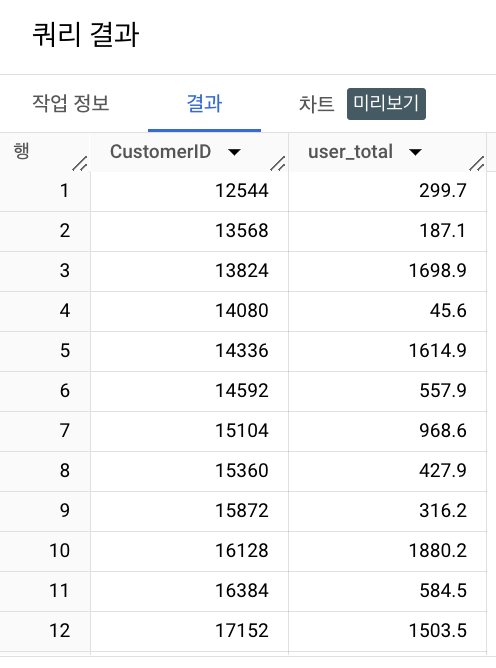

2) 고객별 평균 거래 금액 계산

In [ ]:
- 고객별 평균 거래 금액 계산
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.user_rfm AS   
SELECT
  rf.CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  IFNULL(ut.user_total / rf.purchase_cnt, 0) AS user_average
FROM project-rfm-240115.modulabs_project.user_rf rf
LEFT JOIN (
  -- 고객 별 총 지출액
  SELECT
    CustomerID,
    ROUND(SUM(Quantity * UnitPrice), 1) AS user_total
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
) ut
ON rf.CustomerID = ut.CustomerID;

-- 테이블 확인
SELECT *
FROM project-rfm-240115.modulabs_project.user_rfm

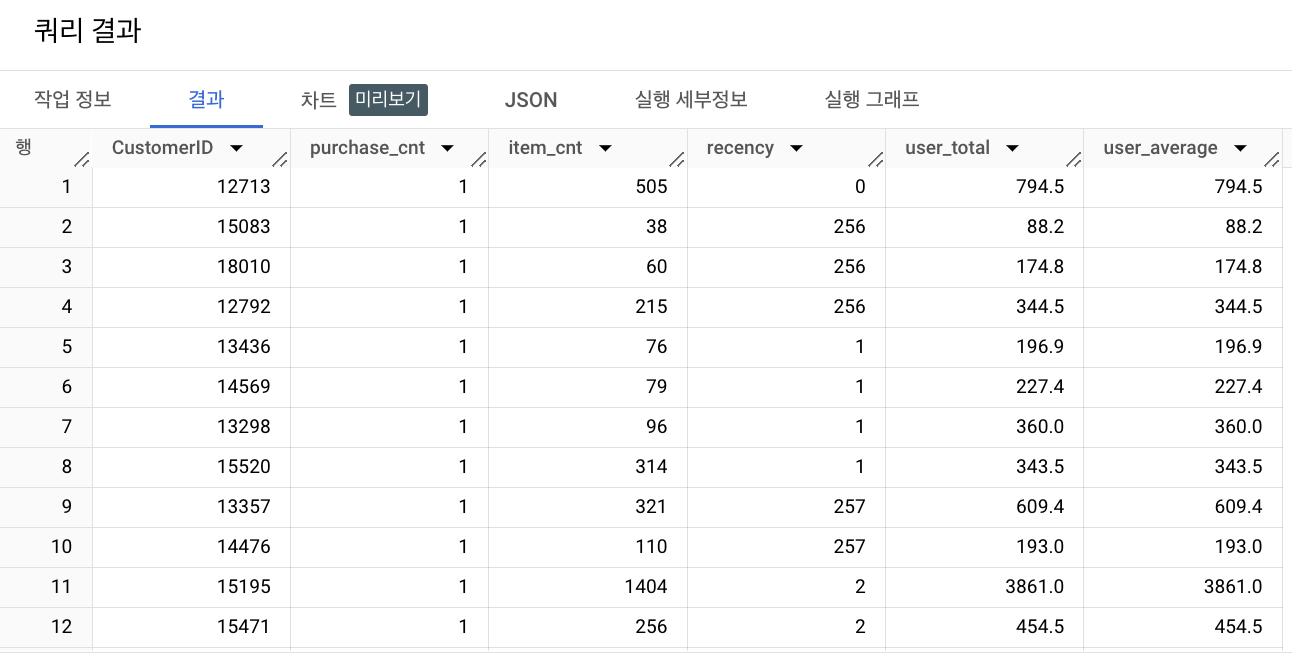

### 통합 테이블 출력

In [ ]:
-- 테이블 확인
SELECT *
FROM project-rfm-240115.modulabs_project.user_rfm

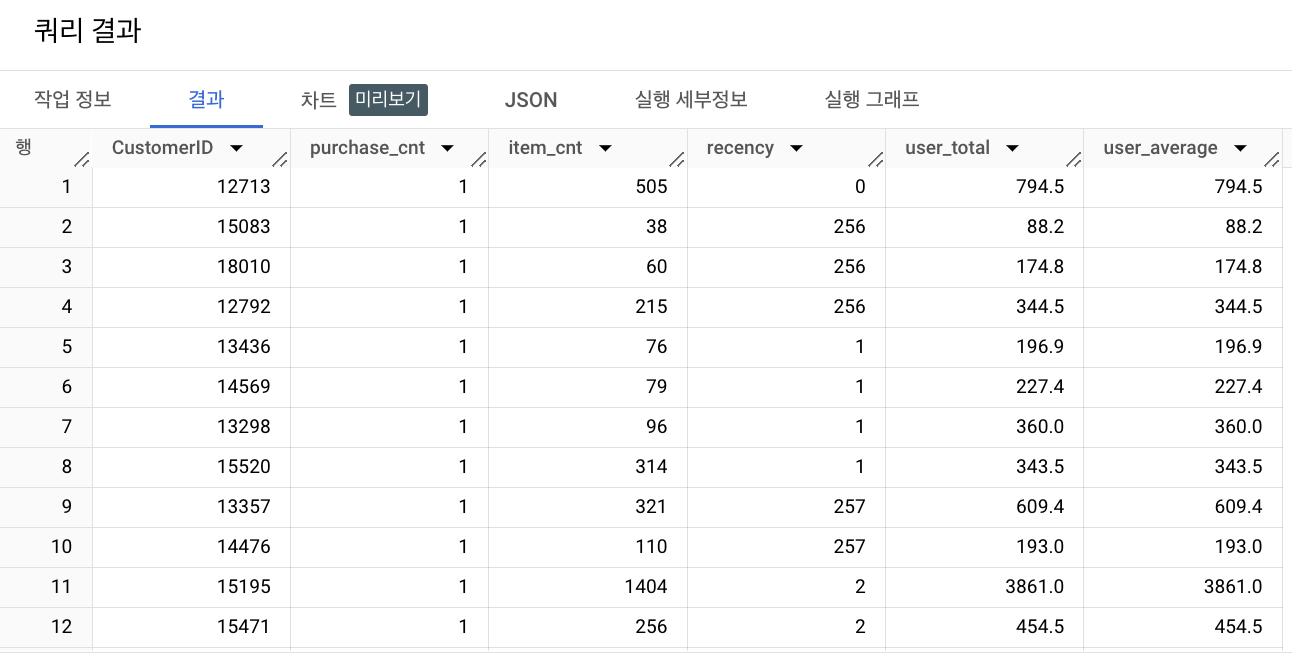

## 추가 Feature 추출

RFM 분석의 허점
- 사이트에 방문한 횟수가 동일하고 비슷한 금액을 지출했지만 구매 패턴이 다른 사람을 분류하지 못한다.
- 커머스에서 구매하는 제품의 폭이 넓은 사람일수록, 장기적으로 봤을 때 온라인 커머스 사이트에서 구매를 더 많이 할 가능성이 높다.
    - 디지털 제품만 구매한느 사람이라면 새로 산 전자 기기가 고장날 때까지 재방문을 하지 않을 수도 있지만, 다양함 상품을 고루 사던 사람이라면 다른 제품을 사러 재방문할 확률이 높다.

유저 구매 패턴을 통한 데이터 분석  
1) 구매하는 제품의 다양성  
2) 평균 구매 주기  
3) 구매 취소 경향성

### 클러스터링 알고리즘

비슷한 특성을 가진 데이터 포인트들을 그룹화하는 기술  
데이터 속에 숨겨진 구조나 패턴을 찾아서 비슷한 데아터들끼리 그룹을 지어주는 것    

활용 사례
1. 고객 세그멘테이션
2. 이미지 분류
3. 자연어 처리
4. 의학 분야
5. 이상 탐지

1) 구매하는 제품의 다양성

In [ ]:
-- 구매하는 제품의 다양성
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.user_data AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM project-rfm-240115.modulabs_project.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;

-- 테이블 확인
SELECT *
FROM project-rfm-240115.modulabs_project.user_data

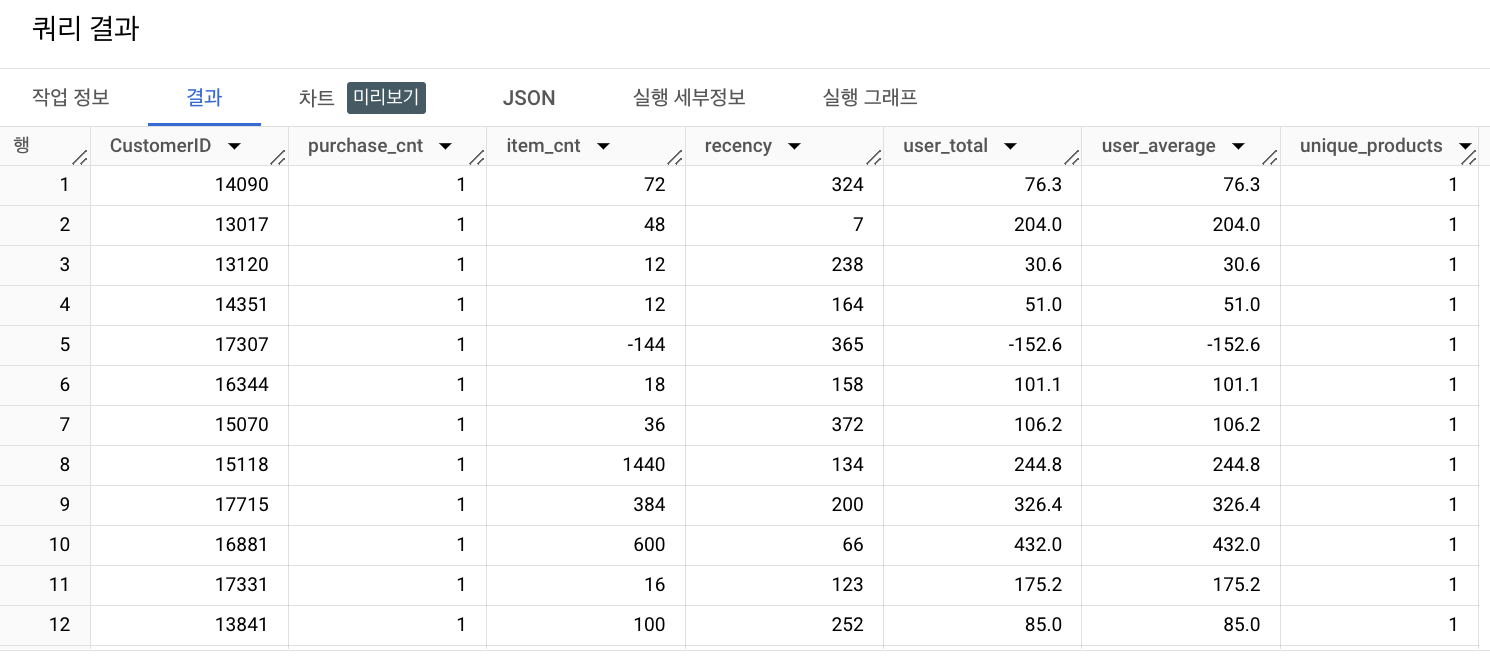

2) 평균 구매 주기

In [ ]:
-- 평균 구매 주기
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.user_data AS 
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      project-rfm-240115.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM project-rfm-240115.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;

SELECT *
FROM project-rfm-240115.modulabs_project.user_data

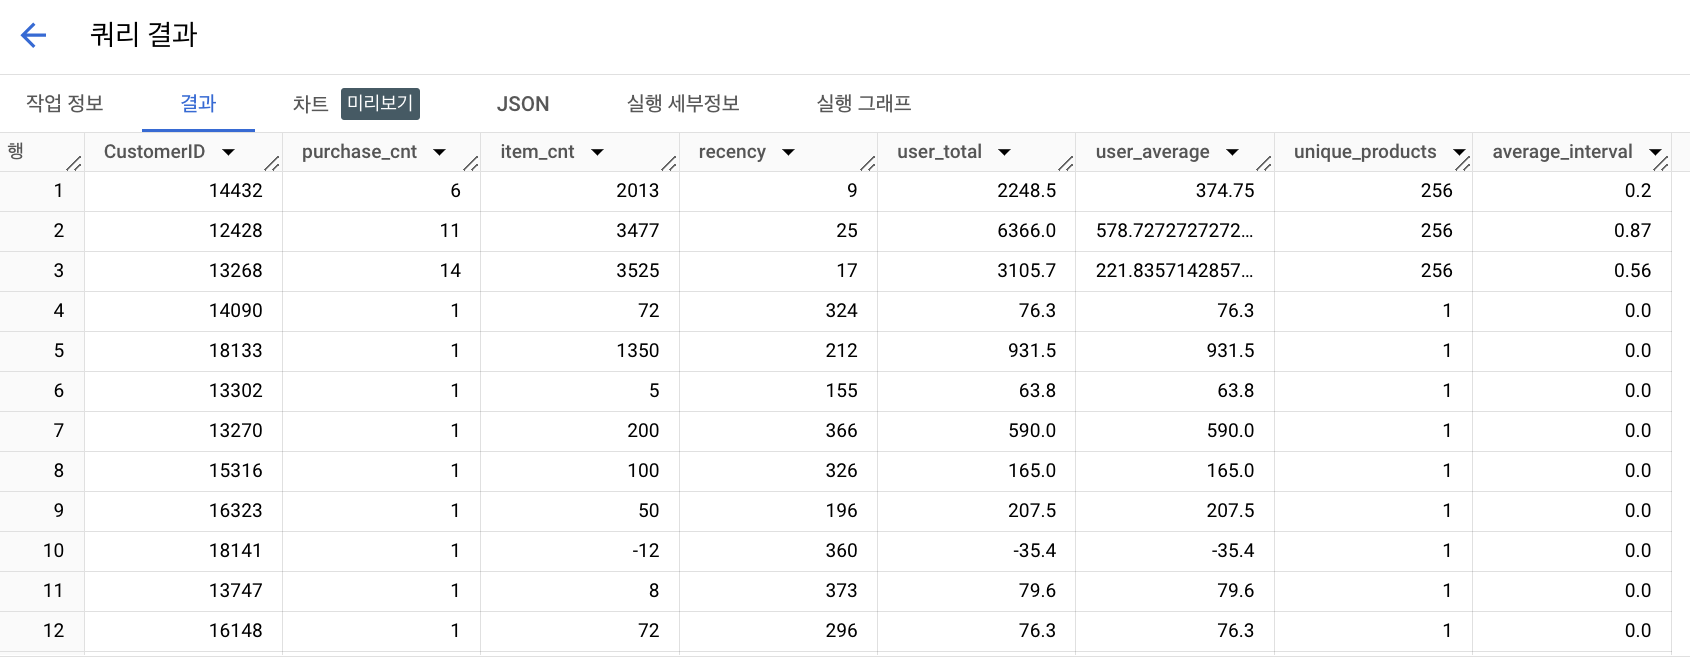

3) 구매 취소 경향성

In [ ]:
-- 구매 취소 경향성
CREATE OR REPLACE TABLE project-rfm-240115.modulabs_project.user_data AS

WITH TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS total_transactions,
    COUNTIF(InvoiceNo LIKE 'C%') AS cancel_frequency
  FROM project-rfm-240115.modulabs_project.data
  GROUP BY CustomerID
)

SELECT u.*, t.* EXCEPT(CustomerID),
       ROUND(t.cancel_frequency / NULLIF(t.total_transactions, 0), 2) AS cancel_rate
FROM project-rfm-240115.modulabs_project.user_rf AS u
LEFT JOIN TransactionInfo AS t
ON u.CustomerID = t.CustomerID;


SELECT *
FROM project-rfm-240115.modulabs_project.user_data

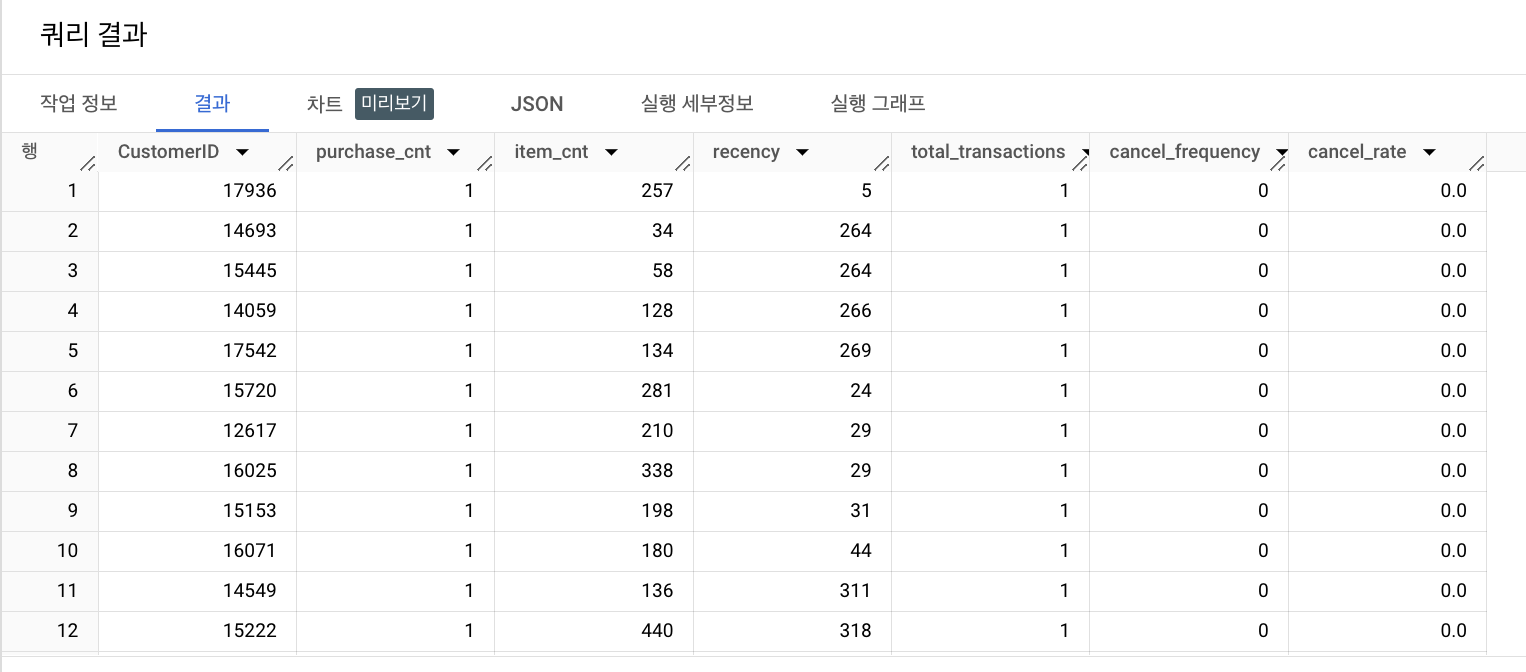

## 회고

1. 어려웠던점
    - SQL 문법 자체가 너무 어려워서 아직 더 공부해야할 거 같다.
2. 에러를 해결했던 점
    - 거의 문법 오류여서 해결했던 게 많이 없었다.
3. 새로운 시도를 했던 점
    - 없었다.
    - 여기서 보는 게 모두 처음보는 거였다..!
4. 다짐 / 아쉬웠던 점
  - SQL을 좀 더 잘 다루고 싶다.
  - 시간이 부족해서 어려웠다..!